In [1]:
# !pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.graphics.gofplots as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.evaluate import permutation_test
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from statsmodels.stats.power import TTestIndPower

In [3]:
stores = pd.read_csv('store.csv')
names = pd.read_csv('state_names.csv')
data = pd.read_csv('store_data.csv', low_memory=False)
store_state = pd.read_csv('store_states.csv')
wt = pd.read_csv('weather.csv')

stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
# stores.describe()
# data
# data.describe()
# data.info()
# type(data['Date'])
# names
# store_state
# wt

In [6]:
# czyszczenie danych weather
wt = wt.drop(columns=['Max_Gust_SpeedKm_h'])
wt['Events'].unique()

array(['Rain', 'Fog-Rain-Snow', nan, 'Snow', 'Rain-Snow', 'Fog-Snow',
       'Rain-Thunderstorm', 'Rain-Snow-Hail', 'Fog-Rain', 'Fog',
       'Fog-Snow-Hail', 'Thunderstorm', 'Fog-Rain-Thunderstorm',
       'Rain-Snow-Hail-Thunderstorm', 'Fog-Rain-Hail', 'Rain-Hail',
       'Rain-Hail-Thunderstorm', 'Fog-Rain-Snow-Hail', 'Fog-Thunderstorm',
       'Rain-Snow-Thunderstorm', 'Fog-Rain-Hail-Thunderstorm',
       'Snow-Hail'], dtype=object)

In [7]:
stores['CompetitionDistance'].fillna(stores['CompetitionDistance'].median(), inplace = True)
wt['CloudCover'].fillna(wt['CloudCover'].median(), inplace = True)
wt['CloudCover'].fillna(wt['CloudCover'].median(), inplace = True)
wt['Max_VisibilityKm'].fillna(0)
wt[ 'Mean_VisibilityKm'].fillna(0)
wt['Min_VisibilitykM' ].fillna(0)
wt['Events'].fillna('Sunny')
stores.fillna(0, inplace = True)

In [8]:
# zastosowane wypełnienie brakujących danych zostało ustawione na podstawie analizy ilości pustych wierszy 
# aby nie odrzucać całch kolumn ustawiono wypełnianie wartościami zerowymi tam, gdzie dane mogą brakować z powodu niezdefiniowanych wartości takich jak brak opadów itp
# kolumny CloudCover i CompetitionDistance wypełniono wartością średnią, ponieważ domyślnie powinny zawierać jakieś przybliżone wartości, które nigdy nie są puste

In [9]:
# scalanie danych do jednego dataframe
wt.rename(columns={'file': 'StateName'}, inplace=True)
merged_data = pd.merge(data, stores, on='Store')
merge_names = pd.merge(store_state, names, on='State')
merged_data = pd.merge(merged_data, merge_names, on='Store', how='inner')
merged = pd.merge(merged_data, wt, on=['Date', 'StateName'])
# merge_names
# merged_data
merged.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State', 'StateName',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Precipitationmm',
       'CloudCover', 'Events', 'WindDirDegrees'],
      dtype='object')

In [10]:
# sprawdzenie ilości pustych wierszy 
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
StoreType,0,0.0
Assortment,0,0.0
CompetitionDistance,0,0.0
CompetitionOpenSinceMonth,0,0.0
CompetitionOpenSinceYear,0,0.0
Promo2,0,0.0
Promo2SinceWeek,0,0.0
Promo2SinceYear,0,0.0
PromoInterval,0,0.0


<Axes: xlabel='Sales', ylabel='Count'>

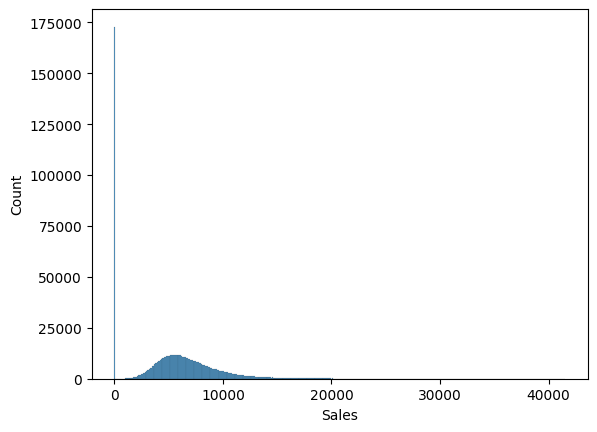

In [11]:
sns.histplot(data['Sales'])     # rozkład wartości Sales

In [12]:
# Średnia wartość sprzedaży dla każdego sklepu
mean = data.groupby('Store')['Sales'].mean()
mean

Store
1        3945.704883
2        4122.991507
3        5741.253715
4        8021.769639
5        3867.110403
            ...     
1111     4342.968153
1112     8465.280255
1113     5516.180467
1114    17200.196391
1115     5225.296178
Name: Sales, Length: 1115, dtype: float64

Text(0, 0.5, 'Sales')

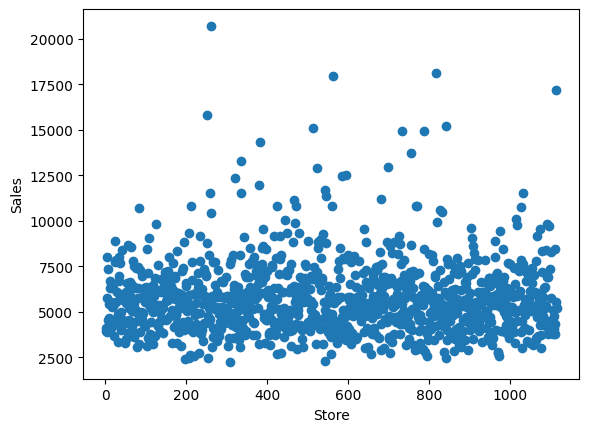

In [13]:
# scatter plot Average Sales/stores
plt.scatter(mean.index, mean.values)
plt.xlabel('Store')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

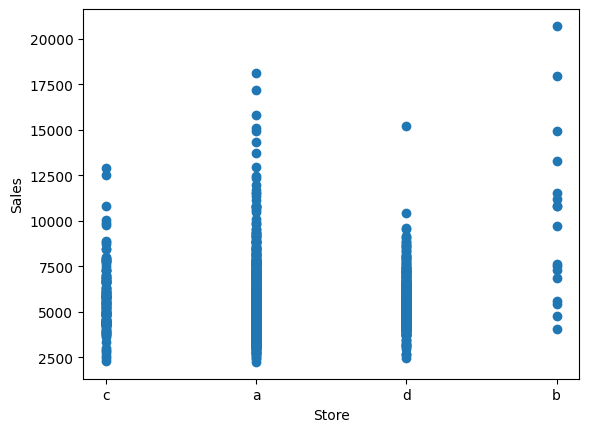

In [14]:
# średnia sprzedaż dla różnych typów sklepów
plt.scatter(stores['StoreType'], mean.values)
plt.xlabel('Store')
plt.ylabel('Sales')

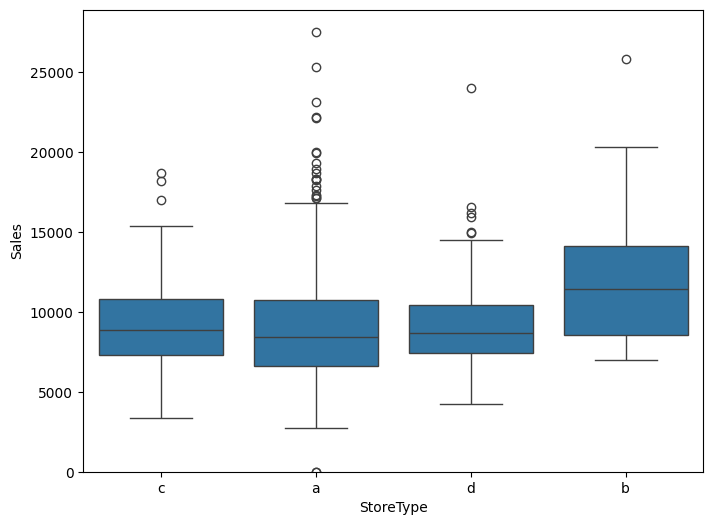

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=stores['StoreType'], y='Sales', data=data)
fig.axis(ymin=0);


Typ sklepu c: 3092 outlierów
Typ sklepu a: 14943 outlierów
Typ sklepu d: 5581 outlierów
Typ sklepu b: 247 outlierów


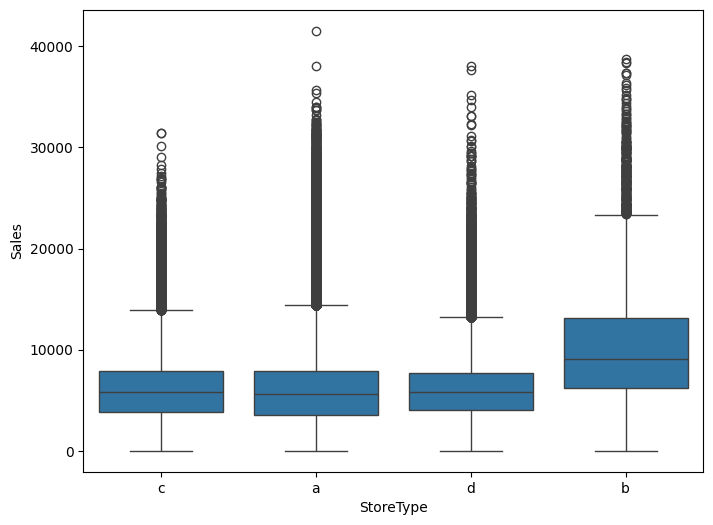

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='StoreType', y='Sales', data=merged_data)
fig.axis()

outliers = []
for store_type in merged_data['StoreType'].unique():
    subset = merged_data[merged_data['StoreType'] == store_type]
    q1 = subset['Sales'].quantile(0.25)
    q3 = subset['Sales'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_count = len(subset[(subset['Sales'] < lower_bound) | (subset['Sales'] > upper_bound)])
    outliers.append((store_type, outliers_count))

for store_type, count in outliers:
    print(f'Typ sklepu {store_type}: {count} outlierów')

# ilość outlierów wartości sprzedaży z przedziału międzykwantylowego, występują jedynie sklepy z większą sprzedażą niż ich średnia wartość

In [17]:
merged_data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [18]:
# ilość sklepów danego typu
count_by_store_type = merged_data['StoreType'].value_counts()
print(count_by_store_type)

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64


/tmp/ipykernel_14003/2169310370.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = merged.corr()


<Axes: >

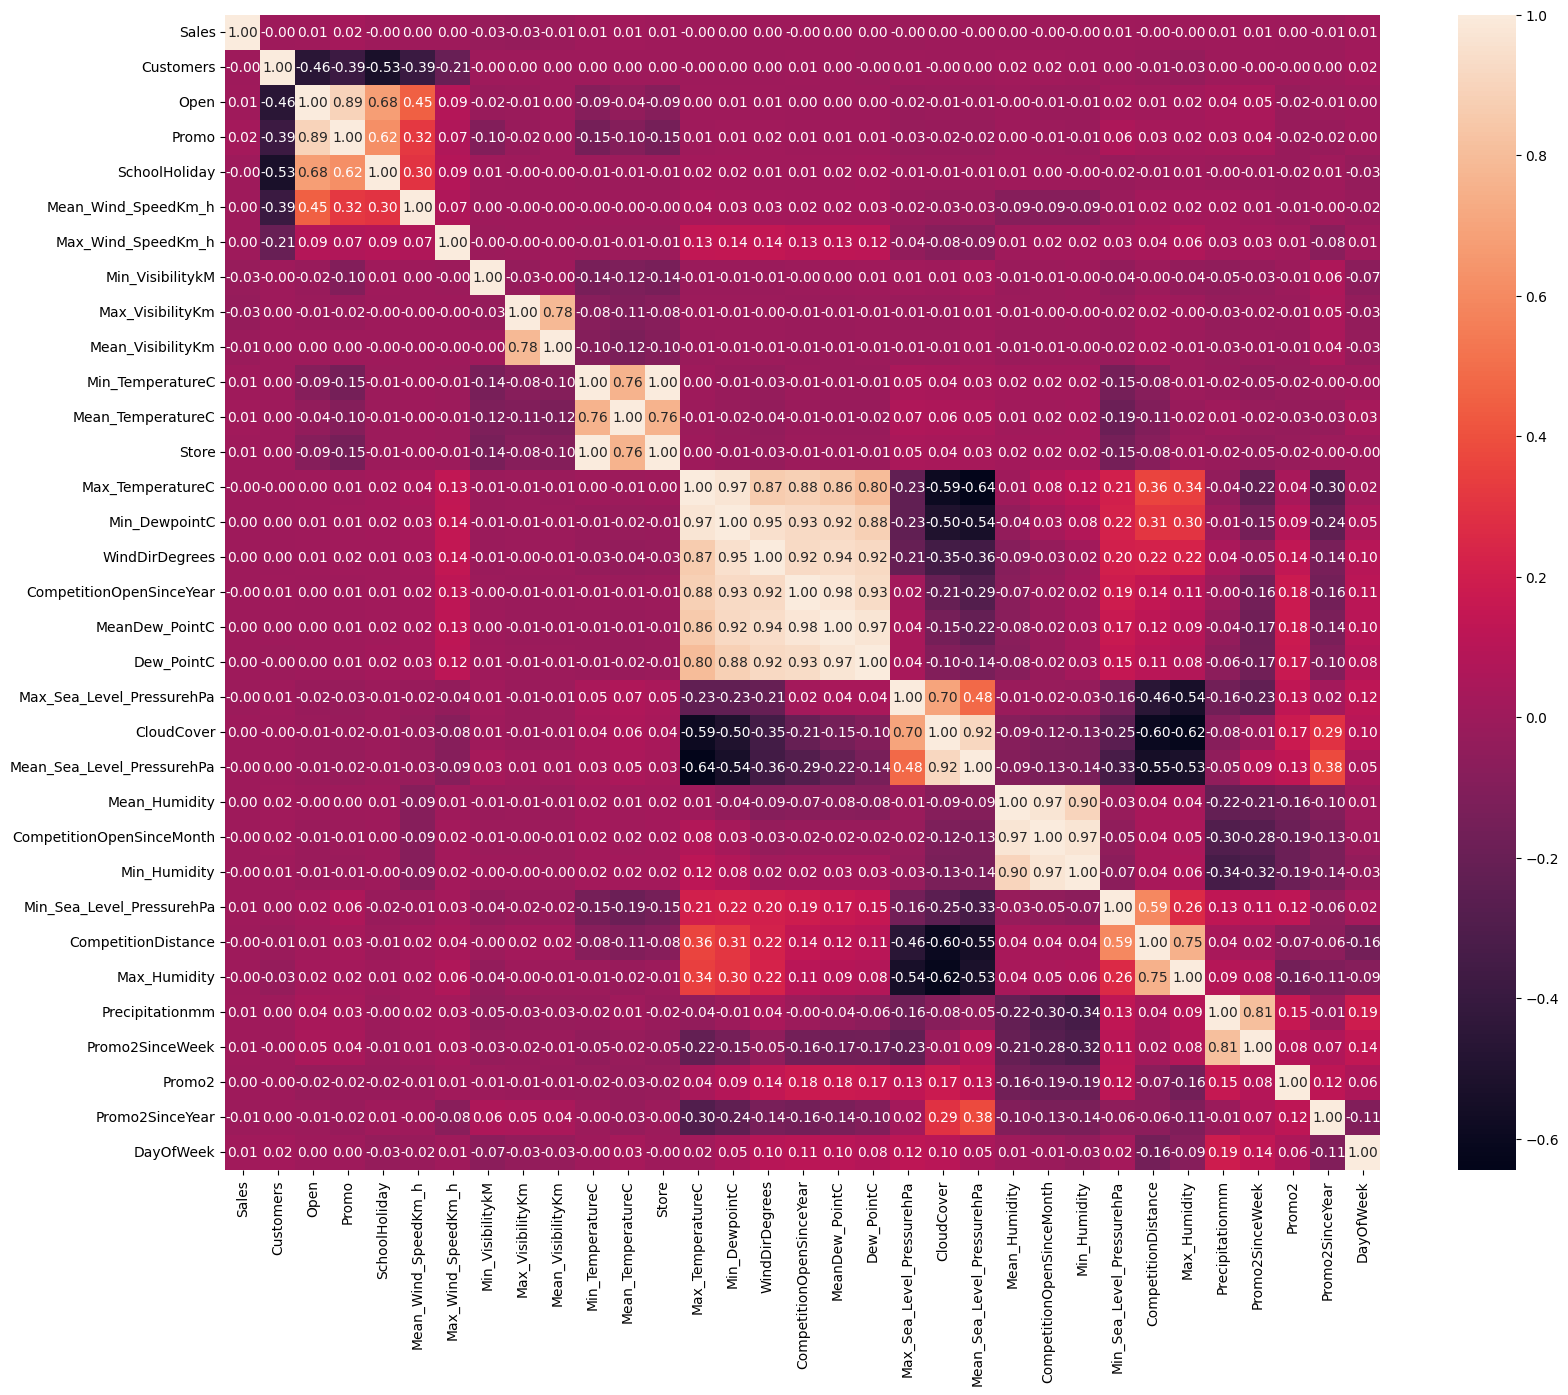

In [19]:
corrmat = merged.corr()
f, ax = plt.subplots(figsize=(20, 15))
cols = corrmat.nlargest(42, 'Sales').index
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

/tmp/ipykernel_14003/1925707743.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = merged_data.corr()


<Axes: >

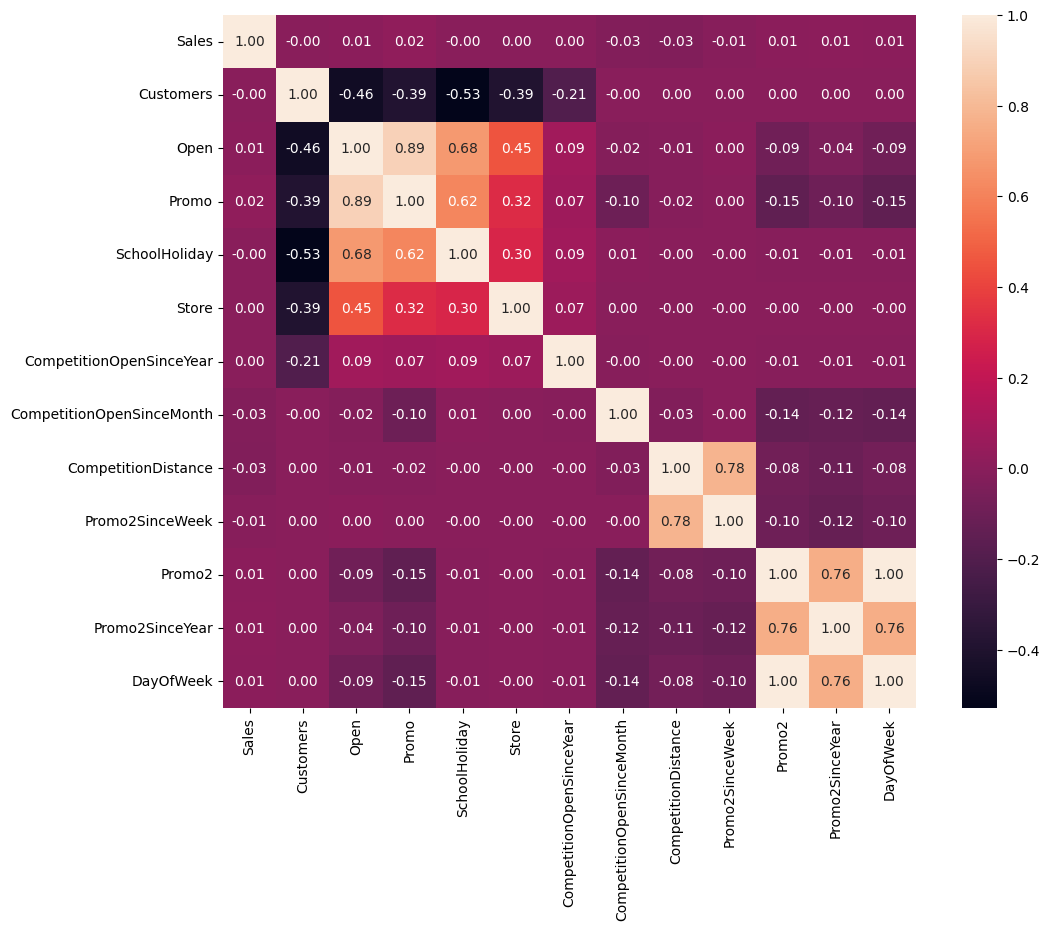

In [20]:
corrmat = merged_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);
cols = corrmat.nlargest(20, 'Sales')['Sales'].index
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [21]:
# macierze korelacji pokazują, że bezpośrednio na siebie wpływają kolumny od siebie w większości zależne, nie ma bezpośredniego powiązania do wartości Sales

In [22]:
# sprzedaż na 1 klienta
merged['ShoppingCart'] = round(merged['Sales']/merged['Customers'],2)
merged['ShoppingCart'] = merged['ShoppingCart'].fillna(0)
# merged.describe()

In [23]:
no_sale = data[(data['Open'] != 0) & (data['Sales'] == 0)]
print("Zerowa sprzedaż w dni otwarte: \n", no_sale)

Zerowa sprzedaż w dni otwarte: 
         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
86825     971          5  2015-05-15      0          0     1      0   
142278    674          4  2015-03-26      0          0     1      0   
196938    699          4  2015-02-05      0          0     1      1   
322053    708          3  2014-10-01      0          0     1      1   
330176    357          1  2014-09-22      0          0     1      0   
340348    227          4  2014-09-11      0          0     1      0   
340860    835          4  2014-09-11      0          0     1      0   
341795    835          3  2014-09-10      0          0     1      0   
346232    548          5  2014-09-05      0          0     1      1   
346734     28          4  2014-09-04      0          0     1      1   
347669     28          3  2014-09-03      0          0     1      1   
348604     28          2  2014-09-02      0          0     1      1   
386065    102          4  2014-07-24      0 

In [24]:
# sklepy zamknięte w święta
no_sale = data[(data['Open'] == 0) & (data['StateHoliday'] != '0')]
no_sale

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
63555,1,4,2015-06-04,0,0,0,1,a,0
63557,3,4,2015-06-04,0,0,0,1,a,0
63563,9,4,2015-06-04,0,0,0,1,a,0
63567,13,4,2015-06-04,0,0,0,1,a,1
63568,14,4,2015-06-04,0,0,0,1,a,0
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [25]:
# sklepy otwarte w święta 
holiday_open = data[(data['Open'] != 0) & (data['StateHoliday'] != '0')]
holiday_open

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
63559,5,4,2015-06-04,5807,625,1,1,a,0
63560,6,4,2015-06-04,5749,614,1,1,a,0
63609,55,4,2015-06-04,5984,702,1,1,a,0
63611,57,4,2015-06-04,9301,870,1,1,a,0
63614,60,4,2015-06-04,10399,850,1,1,a,0
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [26]:
wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15840 entries, 0 to 15839
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   StateName                   15840 non-null  object 
 1   Date                        15840 non-null  object 
 2   Max_TemperatureC            15840 non-null  int64  
 3   Mean_TemperatureC           15840 non-null  int64  
 4   Min_TemperatureC            15840 non-null  int64  
 5   Dew_PointC                  15840 non-null  int64  
 6   MeanDew_PointC              15840 non-null  int64  
 7   Min_DewpointC               15840 non-null  int64  
 8   Max_Humidity                15840 non-null  int64  
 9   Mean_Humidity               15840 non-null  int64  
 10  Min_Humidity                15840 non-null  int64  
 11  Max_Sea_Level_PressurehPa   15840 non-null  int64  
 12  Mean_Sea_Level_PressurehPa  15840 non-null  int64  
 13  Min_Sea_Level_PressurehPa   158

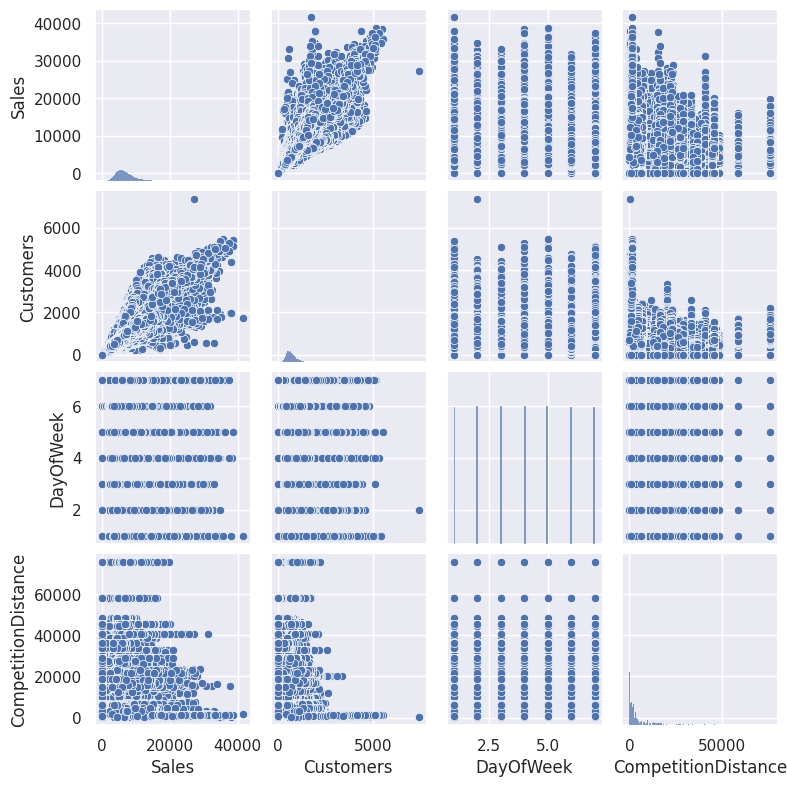

In [27]:
#scatterplot do sprawdzania powiązań między głównymi kolumnami dla pogody i wartości sprzedaży
sns.set()
cols = ['Sales', 'Customers', 'DayOfWeek', 'CompetitionDistance']
# cols = ['Customers','CloudCover','Mean_TemperatureC', 'Events', 'Mean_Wind_SpeedKm_h', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa']
sns.pairplot(merged[cols], height = 2)


In [28]:
clouds = sorted(wt["CloudCover"].unique())
clouds

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [29]:
pivot_states = merged.pivot_table(index=['Store'], columns=['StateName'], values=['Sales'], aggfunc='sum')
pivot_states

Sales                                           \
StateName BadenWuerttemberg Bayern     Berlin     Hamburg     Hessen   
Store                                                                  
1                       NaN    NaN        NaN         NaN  3716854.0   
2                       NaN    NaN        NaN         NaN        NaN   
3                       NaN    NaN        NaN         NaN        NaN   
4                       NaN    NaN  7556507.0         NaN        NaN   
5                       NaN    NaN        NaN         NaN        NaN   
...                     ...    ...        ...         ...        ...   
1111                    NaN    NaN        NaN         NaN        NaN   
1112                    NaN    NaN        NaN         NaN        NaN   
1113                    NaN    NaN        NaN         NaN        NaN   
1114                    NaN    NaN        NaN  16202585.0        NaN   
1115                    NaN    NaN        NaN         NaN  4922229.0   

                                                                      \
StateName Niedersachsen NordrheinWestfalen RheinlandPfalz    Sachsen   
Store                                                                  
1                   NaN                NaN            NaN        NaN   
2                   NaN                NaN            NaN        NaN   
3                   NaN          5408261.0            NaN        NaN   
4                   NaN                NaN            NaN        NaN   
5                   NaN                NaN            NaN  3642818.0   
...                 ...                ...            ...        ...   
1111                NaN          4091076.0            NaN        NaN   
1112                NaN          7974294.0            NaN        NaN   
1113                NaN                NaN            NaN        NaN   
1114                NaN                NaN            NaN        NaN   
1115                NaN                NaN            NaN        NaN   

                                                      
StateName SachsenAnhalt SchleswigHolstein Thueringen  
Store                                                 
1                   NaN               NaN        NaN  
2                   NaN               NaN  3883858.0  
3                   NaN               NaN        NaN  
4                   NaN               NaN        NaN  
5                   NaN               NaN        NaN  
...                 ...               ...        ...  
1111                NaN               NaN        NaN  
1112                NaN               NaN        NaN  
1113                NaN         5196242.0        NaN  
1114                NaN               NaN        NaN  
1115                NaN               NaN        NaN  

[1115 rows x 12 columns]

In [30]:
states_sales = merged.groupby(['State'])[['Sales', 'Customers']].sum()
print(states_sales)
print('Max sales- ', max(states_sales['Sales']), 'max customers- ', max(states_sales['Customers']), 'in land "NW"')
mean_states_sales = merged.groupby(['State'])['ShoppingCart'].mean()
mean_states_sales
# największa sprzedaż jest w landzie najbardziej zaludnionym czyli Nadrenia Północna-Westfalia

            Sales  Customers
State                       
BE      604709903   72259364
BW      355745661   38325902
BY      742361827   70604932
HB,NI   131144129   17089409
HE      603605998   62248656
HH      169053366   22799658
NW     1598936483  178055233
RP      181243703   19075105
SH      618426981   69412329
SN      402442109   43789795
ST      276915114   29821886
TH      188595349   20559486
Max sales-  1598936483 max customers-  178055233 in land "NW"


State
BE       7.079630
BW       8.193801
BY       8.811610
HB,NI    6.784052
HE       8.648039
HH       6.450397
NW       7.666704
RP       8.441026
SH       7.663550
SN       7.609541
ST       7.670588
TH       7.592051
Name: ShoppingCart, dtype: float64

Text(0, 0.5, 'Customers')

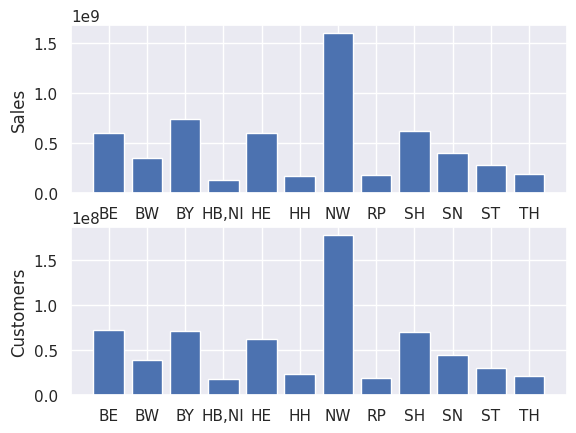

In [31]:
fig, axs = plt.subplots(2,1, squeeze=False)
axs[0, 0].bar(states_sales.index, states_sales['Sales'])
axs[1, 0].bar(states_sales.index, states_sales['Customers'])
axs[0, 0].set_ylabel('Sales')
axs[1, 0].set_ylabel('Customers')

In [32]:
# średnia wartość koszyka najmniejsza jest w rejonach gęsto zamieszkanych takich jak np HB,NI oraz HH
# może to świadczyć, że sklepy w centrum miast są częsciej odwiedzane

In [33]:
merged['StateName'].unique() # brakuje 4 landów w danych 

array(['Hessen', 'Thueringen', 'NordrheinWestfalen', 'Berlin', 'Sachsen',
       'SchleswigHolstein', 'Niedersachsen', 'Bayern',
       'BadenWuerttemberg', 'RheinlandPfalz', 'SachsenAnhalt', 'Hamburg'],
      dtype=object)

(5.0, 10.0)

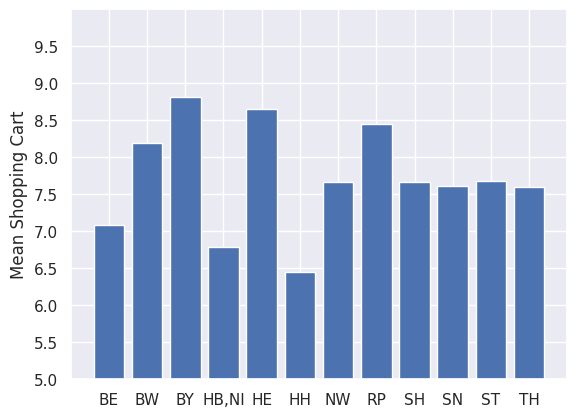

In [34]:
plt.bar(states_sales.index, mean_states_sales.values)
plt.ylabel('Mean Shopping Cart')
plt.yticks(np.arange(0, 10, 0.5))
plt.ylim(5, 10)


In [35]:
# średnia wartość koszyka jest większa w rejonach o małej gęstości zaludnienia
# wynika to z faktu, że w dużych miastach jest więcej sklepów, a ludzie robią mniejsza zakupy ale częściej co odbija się na maksymalnej liczbie klientów


In [36]:
# grupowanie miesięcy
merged['Date'] = pd.to_datetime(merged['Date'])
months = merged.groupby([merged['Date'].dt.to_period("M"), 'StoreType'])[['Sales', 'ShoppingCart']].mean()
# result = months[['Sales', 'ShoppingCart']].mean()
# result
months

Sales  ShoppingCart
Date    StoreType                            
2013-01 a           5295.606773      7.165941
        b           7825.675522      4.383643
        c           5166.859852      6.785070
        d           4957.471728      9.127572
2013-02 a           5557.974430      7.404913
...                         ...           ...
2015-06 d           6155.540805      9.964062
2015-07 a           6027.736899      8.067267
        b          10874.925996      5.212258
        c           6066.334133      7.904209
        d           6142.896088     10.320245

[124 rows x 2 columns]

In [37]:
# średnia wartość sprzedaży i koszyka w poszczególnych miesiącach z podziałem na typ sklepu
pivot_months = merged.pivot_table(index=merged['Date'].dt.to_period("M"), columns=['StoreType'], values=['Sales', 'ShoppingCart'], aggfunc='mean')
pivot_months

Sales                                         ShoppingCart  \
StoreType            a             b            c            d            a   
Date                                                                          
2013-01    5295.606773   7825.675522  5166.859852  4957.471728     7.165941   
2013-02    5557.974430   8515.915966  5488.964044  5239.040948     7.404913   
2013-03    5831.116386   9091.789374  5891.525719  5611.640897     7.168246   
2013-04    5549.425471   8908.109804  5443.540991  5219.956897     7.111105   
2013-05    5353.131497   9697.730550  5364.180689  5171.427327     6.605043   
2013-06    5411.409192   9297.239216  5357.388514  5214.933333     7.179344   
2013-07    6085.029043   9315.700190  5879.792502  5876.826845     7.684766   
2013-08    5720.036491   9078.432638  5673.886007  5606.162681     7.468581   
2013-09    5318.562735   9317.209804  5248.528829  5167.191092     7.079157   
2013-10    5437.853231   9690.223909  5345.177201  5241.999629     7.151910   
2013-11    5832.438261  10105.170588  5914.404505  5691.905747     7.519413   
2013-12    6628.922731  11188.191651  6889.885789  6534.541342     7.258592   
2014-01    5401.431197   9408.425047  5335.615083  5331.223211     7.198080   
2014-02    5701.070301   9958.539916  5646.799469  5612.359811     7.419351   
2014-03    5550.226717   9831.172676  5437.254795  5498.180386     7.259455   
2014-04    5778.743023  10408.949020  5705.355180  5703.116571     7.085784   
2014-05    5551.810524  10541.174573  5563.590453  5562.144698     7.111535   
2014-06    5626.607198  10690.837255  5514.650000  5602.792337     6.978803   
2014-07    5977.266721  10346.173387  5851.276119  5856.210584     7.669363   
2014-08    5612.697783  10007.586694  5586.724362  5490.969917     7.287006   
2014-09    5849.572651  10155.179167  5692.875373  5724.589763     7.419624   
2014-10    5619.999253  10462.764113  5585.746028  5506.551891     7.186596   
2014-11    6104.279794  11160.800000  6192.245771  6019.654557     7.407667   
2014-12    6822.478827  11900.953629  7248.308137  6832.533768     7.648509   
2015-01    5623.919140   9967.785579  5754.426330  5768.985910     7.581143   
2015-02    5621.915816  10421.132353  5667.277027  5651.353654     7.605814   
2015-03    5865.646876  10599.092979  5846.529861  5910.027809     7.640827   
2015-04    5826.206589  10975.201961  5826.604955  5864.953640     7.308375   
2015-05    5352.071589  11140.709677  5359.486269  5450.784205     6.818446   
2015-06    6132.770598  11080.150980  6011.444369  6155.540805     7.842720   
2015-07    6027.736899  10874.925996  6066.334133  6142.896088     8.067267   

                                          
StoreType         b         c          d  
Date                                      
2013-01    4.383643  6.785070   9.127572  
2013-02    4.432500  7.044122   9.394062  
2013-03    4.451063  6.838383   9.089513  
2013-04    4.439529  6.889840   9.040581  
2013-05    4.673321  6.457953   8.314709  
2013-06    4.537588  7.027304   9.133774  
2013-07    4.768956  7.516029   9.816452  
2013-08    4.818292  7.302792   9.517765  
2013-09    4.967627  6.897061   9.024724  
2013-10    4.998577  6.935942   9.137634  
2013-11    5.144078  7.314245   9.569936  
2013-12    5.599089  7.042238   9.208294  
2014-01    5.146357  6.937964   9.193052  
2014-02    5.086050  7.210053   9.497771  
2014-03    5.052315  7.058882   9.321970  
2014-04    5.100216  6.889714   9.010455  
2014-05    5.072334  6.932578   9.066815  
2014-06    5.090745  6.860534   8.850679  
2014-07    4.972500  7.466302   9.791636  
2014-08    5.097581  7.057253   9.231636  
2014-09    5.097479  7.252522   9.436653  
2014-10    5.175040  6.993469   9.116113  
2014-11    5.451625  7.285363   9.422552  
2014-12    5.759012  7.422378   9.662592  
2015-01    5.328710  7.327476   9.649137  
2015-02    5.268739  7.354011   9.695842  
2015-03    5.306262  7.415078   9.783306  
2015-04    5.343157  7.105903   9.268435

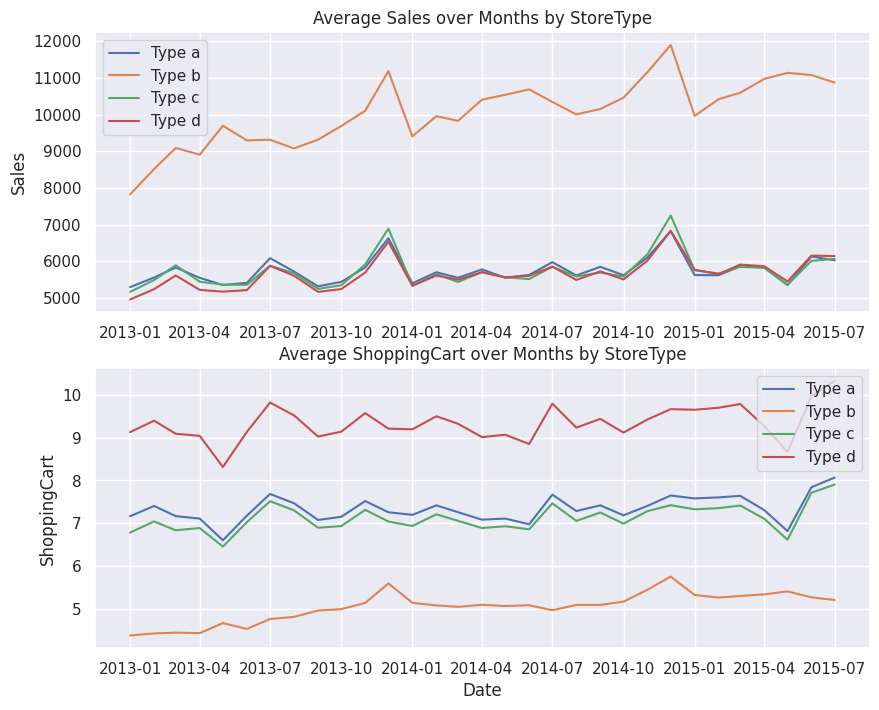

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for store_type in pivot_months.columns.levels[1]:
    axs[0].plot(pivot_months.index.to_timestamp(), pivot_months['Sales', store_type], label=f'Type {store_type}')

axs[0].set_ylabel('Sales')
axs[0].set_title('Average Sales over Months by StoreType')
axs[0].legend()

# Tworzenie wykresów dla ShoppingCart
for store_type in pivot_months.columns.levels[1]:
    axs[1].plot(pivot_months.index.to_timestamp(), pivot_months['ShoppingCart', store_type], label=f'Type {store_type}')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('ShoppingCart')
axs[1].set_title('Average ShoppingCart over Months by StoreType')
axs[1].legend()

plt.show()


In [39]:
# na wykresie widać zauważalną sezonowość w okresach świąt Bożego narodzenia i wialkanocy, dodatkowo w miesiącach letnich również jest wzrost sprzedaży
#W sklepach typu b jest największa sprzedaż, ale wartość średnia koszyka jest najmniejsza, stąd wniosek, że są to sklepy w obszarach miejskich
# gdzie zakupy robi się często, ale mniejsze. Podobnie sklepy typu d mają średnią sprzedaż porównywalną, jednak w tych sklepach zakupy robi się
# zdecydowanie rzadziej, przez co średnia wartość koszyka jest większa, mogą to być obszary wiejskie, są one zdala od konkurencji.

In [40]:
pivot_weeks = merged.pivot_table(index=merged['Date'].dt.to_period("W"), columns=['StoreType'], values=['Sales', 'ShoppingCart'], aggfunc='mean')
pivot_weeks

Sales                                          \
StoreType                        a             b            c            d   
Date                                                                         
2012-12-31/2013-01-06  3886.008308   6704.970588  4031.847973  3751.327107   
2013-01-07/2013-01-13  6420.244186   8261.756303  6184.775097  6087.740969   
2013-01-14/2013-01-20  4484.877314   7625.302521  4382.013514  4117.945402   
2013-01-21/2013-01-27  5954.033935   8741.151261  5855.865830  5682.674877   
2013-01-28/2013-02-03  5006.121025   7891.243697  4906.060811  4658.660920   
...                            ...           ...          ...          ...   
2015-06-29/2015-07-05  7073.226626  12206.310924  6928.422780  7082.720443   
2015-07-06/2015-07-12  5230.953014  10244.638655  5207.047297  5227.599754   
2015-07-13/2015-07-19  6527.249644  11532.126050  6587.792471  6693.478243   
2015-07-20/2015-07-26  4947.032036   9799.596639  4939.000965  5037.916667   
2015-07-27/2015-08-02  8340.270764  11529.941176  8486.314865  8544.132184   

                      ShoppingCart                                 
StoreType                        a         b         c          d  
Date                                                               
2012-12-31/2013-01-06     5.502456  4.322059  5.143086   6.958300  
2013-01-07/2013-01-13     7.784656  4.452521  7.382066   9.891026  
2013-01-14/2013-01-20     6.845147  4.298992  6.440598   8.694093  
2013-01-21/2013-01-27     7.754385  4.627059  7.391438   9.929717  
2013-01-28/2013-02-03     7.134979  4.213613  6.759488   9.078514  
...                            ...       ...       ...        ...  
2015-06-29/2015-07-05     8.566184  5.300840  8.378446  10.922250  
2015-07-06/2015-07-12     7.435389  5.039244  7.237249   9.506039  
2015-07-13/2015-07-19     8.252784  5.405210  8.125068  10.541835  
2015-07-20/2015-07-26     7.383764  4.952353  7.215261   9.442118  
2015-07-27/2015-08-02    10.102910  5.705412  9.986851  12.989925  

[135 rows x 8 columns]

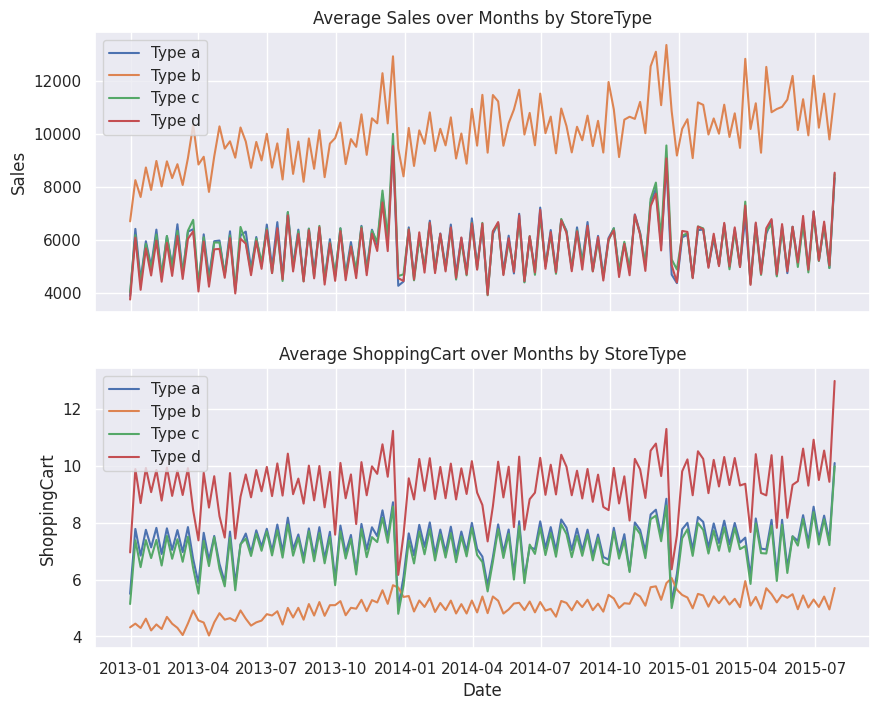

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for store_type in pivot_weeks.columns.levels[1]:
    axs[0].plot(pivot_weeks.index.to_timestamp(), pivot_weeks['Sales', store_type], label=f'Type {store_type}')

axs[0].set_ylabel('Sales')
axs[0].set_title('Average Sales over Months by StoreType')
axs[0].legend()

for store_type in pivot_weeks.columns.levels[1]:
    axs[1].plot(pivot_weeks.index.to_timestamp(), pivot_weeks['ShoppingCart', store_type], label=f'Type {store_type}')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('ShoppingCart')
axs[1].set_title('Average ShoppingCart over Months by StoreType')
axs[1].legend()

plt.show()


In [42]:
# Sytuacja wygląda podobnie w rozbiciu na tygodnie, średnia wartość w każdym tygodniu sklepów A,C,D się praktycznie pokrywa, 
# różni się notomiast średnia dla typu B
# średnia sprzedaż zmienia się co 2 tygodnie, najpierw rośnie potem maleje,
# Średnia wartość koszyka dla typu sklepu d może też mieć wpływ na jego asortyment
saturday_open = merged[(merged['Open'] != 1) & (merged['DayOfWeek'] == 6)]
saturday_open.groupby(['StoreType'])['Sales'].count()  # ilość sklepów zamkniętych w soboty


StoreType
a    370
b     37
c    100
d    165
Name: Sales, dtype: int64

In [43]:
stats.pearsonr(merged.Customers, merged.Sales)[0] # silne, oczywiste powiązanie

0.8947107733017114

In [44]:
stats.pearsonr(merged.Customers, merged.DayOfWeek)[0] 

-0.38644472139826136

In [45]:
mon= merged.loc[(merged.DayOfWeek == 1) & (merged.Sales > 0)]['Sales']
tue= merged.loc[(merged.DayOfWeek == 2) & (merged.Sales > 0)]['Sales']
wed= merged.loc[(merged.DayOfWeek == 3) & (merged.Sales > 0)]['Sales']
thu= merged.loc[(merged.DayOfWeek == 4) & (merged.Sales > 0)]['Sales']
fri= merged.loc[(merged.DayOfWeek == 5) & (merged.Sales > 0)]['Sales']
sat= merged.loc[(merged.DayOfWeek == 6) & (merged.Sales > 0)]['Sales']

f_oneway(mon, tue,wed, thu, fri, sat ) # ANOVA
# zbiory są różne od siebe, istnieją różnice pomiędzy sprzedażą w dany dzień tygodnia

F_onewayResult(statistic=8939.052661341113, pvalue=0.0)

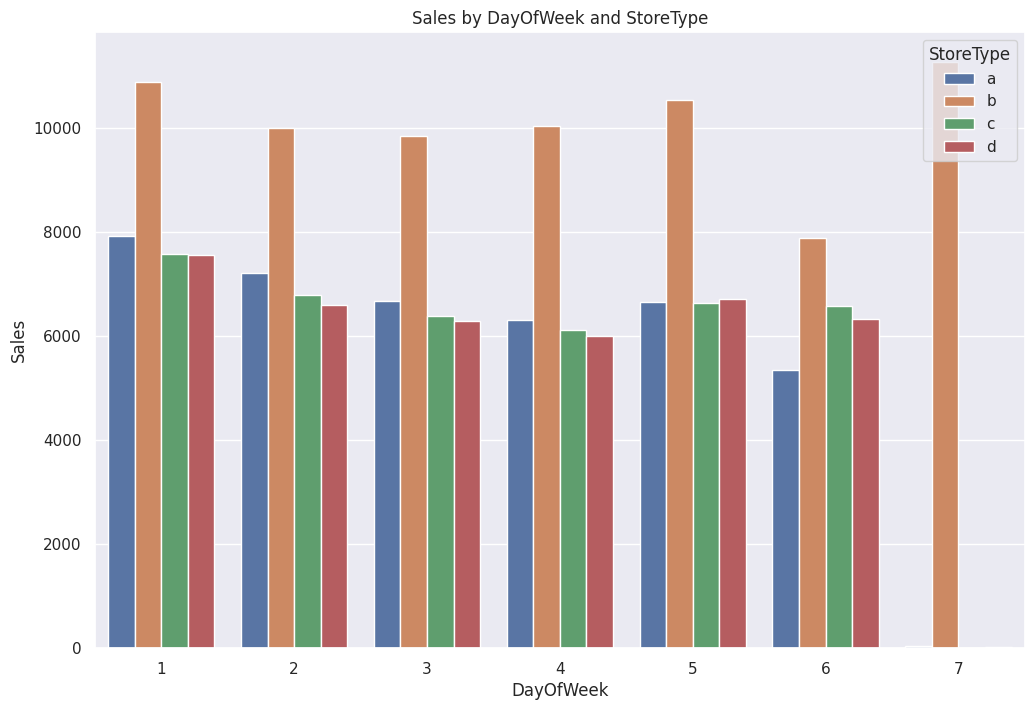

In [46]:
dates = merged.groupby(['StoreType', 'DayOfWeek'])['Sales'].mean()
dates
df_reset = dates.reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='DayOfWeek', y='Sales', hue='StoreType', data=df_reset)
plt.title('Sales by DayOfWeek and StoreType')
plt.xlabel('DayOfWeek')
plt.ylabel('Sales')
plt.show()

In [47]:
# Z wykresu widać, że największa sprzedaż wstępuje w poniedziałki oraz piątki, w niedziele są otwarte tylko sklepy typu B
# Potwierdza się też fakt, że dzień typogdnia ma wpływ na wartość sprzedaży
# Dodatkowo sprzedaż można powiązać z występowanie promocji, która jest znacznie rzadziej w weekendy niż w ciągu tygodnia


In [48]:
no_promo = merged.loc[(merged.Promo == 0) & (merged.Sales > 0)]['Sales']
no_promo

582        15998
584         7750
632        13966
672         4364
673         9229
           ...  
1017177     4344
1017178     7222
1017179     3500
1017180    20642
1017188    17267
Name: Sales, Length: 467463, dtype: int64

In [49]:
promo = merged.loc[(merged.Promo == 1)& (merged.Sales > 0)]['Sales']
promo

0           5263
1          10022
2          11204
3          10335
4           8897
           ...  
1017036     6478
1017037     6927
1017038    11519
1017039     6508
1017040    21237
Name: Sales, Length: 376875, dtype: int64

<Axes: xlabel='Sales', ylabel='Count'>

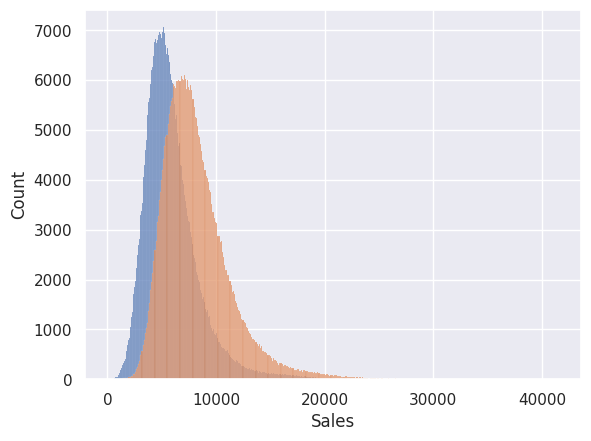

In [50]:
sns.histplot(no_promo)
sns.histplot(promo)

<Axes: xlabel='Sales', ylabel='Count'>

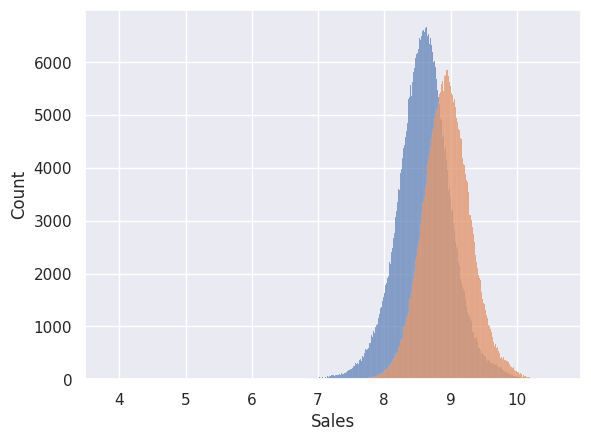

In [51]:
promo_log = np.log(promo)
no_promo_log = np.log(no_promo)
sns.histplot(no_promo_log)
sns.histplot(promo_log)

In [52]:
stats.ttest_ind(promo_log, no_promo_log)

TtestResult(statistic=406.64162359104716, pvalue=0.0, df=844336.0)

In [53]:
promotion_samples = promo
no_promotion_samples = no_promo.sample(len(promo), random_state=0)
p_value = permutation_test(promotion_samples, no_promotion_samples,
                            method='approximate',
                            num_rounds=1000,
                            seed=0)
p_value   
# wartość pola Promo ma statystyczny wpływ na wartość Sales
# wartości p_value pozwalają odrzucić hipotezę zerową, obecność promocji wpływa na wartość Sales

0.000999000999000999

In [54]:
merged.loc[(merged.DayOfWeek<7) & (merged.Promo ==0)]['Sales'].mean()

5661.495799950041

In [55]:
merged.loc[(merged.DayOfWeek<7) & (merged.Promo ==1)]['Sales'].mean() # po wartości średniej widać wpływ promocji na średnią sprzedaż

7991.152045969903

Nazwy składowych:
Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'WindDirDegrees', 'ShoppingCart'],
      dtype='object')
33


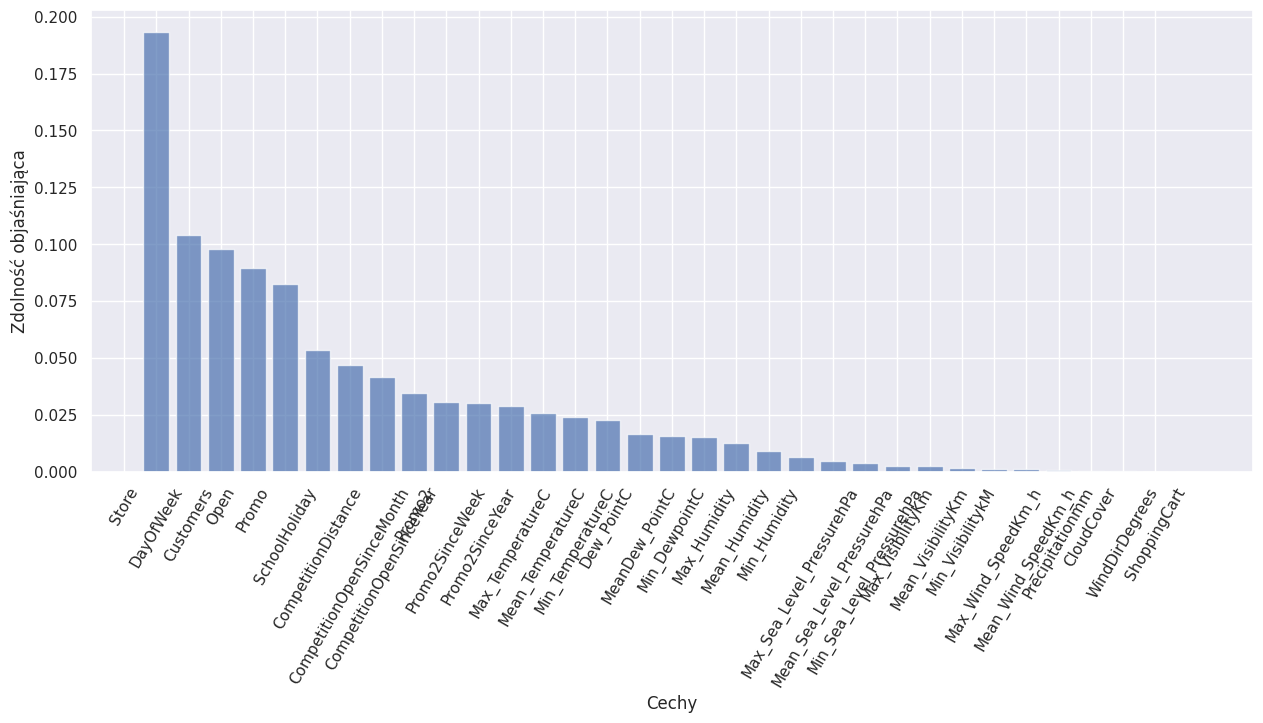

In [56]:
X = merged.drop('Sales', axis=1).select_dtypes(include=['number'])
X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
component_names = X.columns
print("Nazwy składowych:")
print(component_names)
print(len(component_names))

plt.figure(figsize=(15, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('Cechy')
plt.ylabel('Zdolność objaśniająca')
plt.xticks(range(0, len(pca.explained_variance_ratio_) ), [component_names[i] for i in range(0, len(pca.explained_variance_ratio_) )], rotation=60)
plt.show()

In [57]:
# wykres PCA pozwala w szybki sposób obniżyć wymiarowość zakładanego modelu do najbardziej charakterystycznych cech wpływających na sprzedaż
# na podstawie wykresu ograniczono ilość cech do 7 początkowych oraz dodano wartości występujące dla pogody, tj Mean_TemperatureC i Mean_Sea_Level_PressurehPa


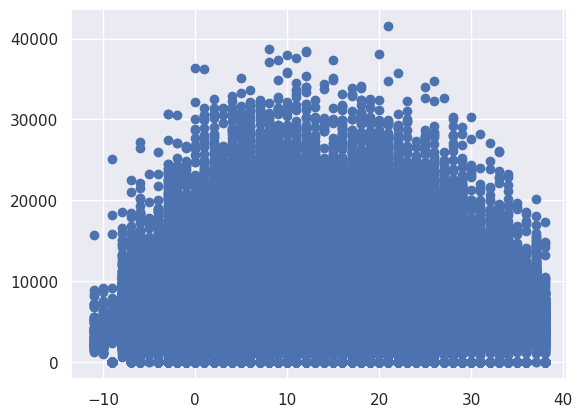

In [58]:
plt.scatter(merged.Max_TemperatureC, merged.Sales)

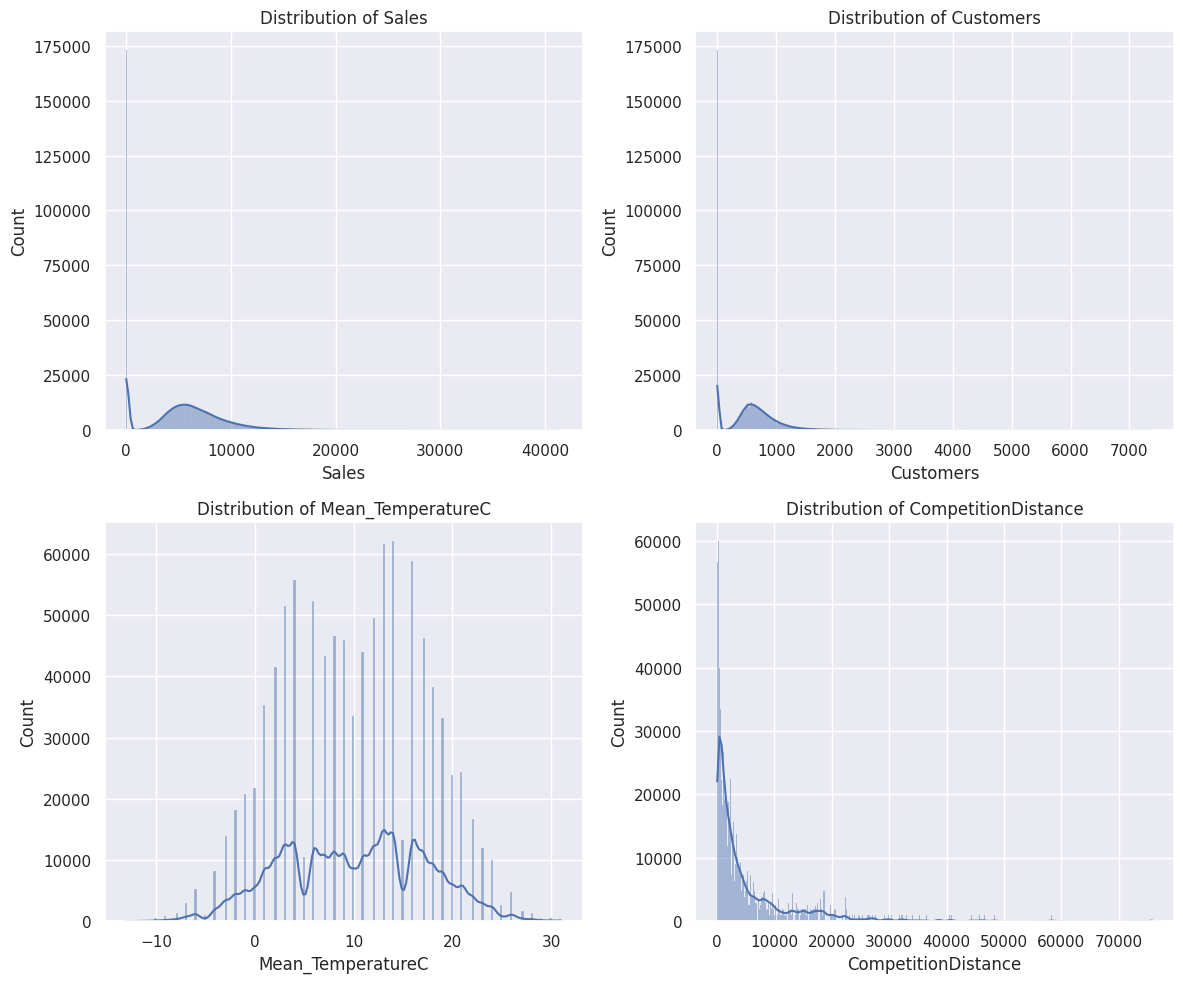

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(merged['Sales'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Sales')
sns.histplot(merged['Customers'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Customers')
sns.histplot(merged['Mean_TemperatureC'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Mean_TemperatureC')
sns.histplot(merged['CompetitionDistance'], kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of CompetitionDistance')
plt.tight_layout()
plt.show()
# Dla lepszego zobrazowania rozkładów cech wyznaczono ich histploty

In [60]:
# z rozkładów czynników analizowanych za pomocą regresji można zauważyć, że mają one pozytywny współczynnik skośności
# aby móc lepiej je porównywać należy je znormalizować stosując funkcję logarytmiczną dla wartości różnych od zera

In [61]:
merged['Saleslog'] = merged['Sales'].apply(lambda x: np.log(x) if x > 0 else x)
merged['Customerslog'] = merged['Customers'].apply(lambda x: np.log(x) if x > 0 else x)
merged['Mean_TemperatureClog'] = merged['Mean_TemperatureC'].apply(lambda x: np.log(x) if x > 0 else x)
merged['CompetitionDistancelog'] = merged['CompetitionDistance'].apply(lambda x: np.log(x) if x > 0 else x)

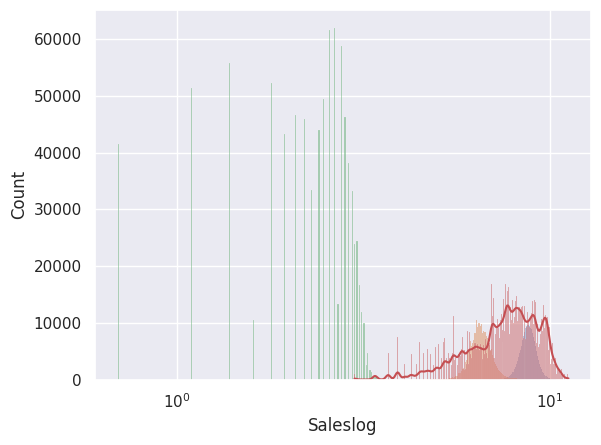

In [62]:
sns.histplot(merged['Saleslog'], log_scale=True,legend = True, kde=True);
sns.histplot(merged['Customerslog'], log_scale=True, legend = True, kde=True);
sns.histplot(merged['Mean_TemperatureClog'],log_scale=True, legend = True, kde=True);
sns.histplot(merged['CompetitionDistancelog'],  legend = True, kde=True);

In [63]:
searched = 'Saleslog'
dependent = 'Customerslog'
model = ols(f'{searched} ~ {dependent} + StoreType + CloudCover + DayOfWeek + Promo + Open + SchoolHoliday + Mean_TemperatureC + CompetitionDistancelog', data=merged)
res = model.fit()
print(res.summary())
# na podstawie wcześniejszych testów oraz przeprowadzonych analiz wyznaczono cechy charakterystyczne do stworzenia wiernego modelu ols
# wynik modelu ols dla R-squared: 0.998
# Wyznaczona regrsja z modelu jest bardzo dobrym odwzorowaniem zależności czynników analitycznych na regresję wartości sprzedaży
# aby móc porównać wyniki zastosowano także las drzew decyzyjnych poniżej

                            OLS Regression Results                            
Dep. Variable:               Saleslog   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.156e+07
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:16:08   Log-Likelihood:             4.4613e+05
No. Observations:             1017209   AIC:                        -8.922e+05
Df Residuals:                 1017197   BIC:                        -8.921e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [64]:
res.mse_model

1012096.2765830233

In [65]:
def encode_categorical_columns(dataframe, columns):
    label_df = dataframe.copy()
    label_encoder = LabelEncoder()
    for column in columns:
        label_df[column] = label_encoder.fit_transform(label_df[column])
    return label_df

merged_encoded = encode_categorical_columns(merged, ['StoreType', 'SchoolHoliday'])
# do wyznaczenia regresji należy zamienić zmienne kategoryczne na wartości zenkodowane

In [66]:
selected_columns = ['StoreType', 'Customerslog','CloudCover', 'DayOfWeek', 'Promo', 'Open', 'SchoolHoliday', 'Mean_TemperatureC', 'CompetitionDistancelog']
y_train = merged['Saleslog']
x_train = merged_encoded[selected_columns]
x_train_scaled = StandardScaler().fit_transform(x_train)
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
predictions = regressor.predict(x_train)
r2_score(y_train, predictions)            
# wynik regresji za pomocą drzew decyzyjnych wynosi 99,99% 
# jest to wartość porównywalna do modelu z ols, co pozwala stwierdzić, ze czynniki zostały poprawnie dobrane wyznaczenia regeresji 

0.9999119975400252


0.9999119975400252

In [67]:
# PODSUMOWANIE FAZY 1 - ANALIZY CZYNNIKÓW
# Dla wartości sprzedaży największy wpływ mają: dni tygodnia, obecność promocji, odległość od konkurencji, rodzaj sklepu oraz dni wolne.
# Rodzaje sklepów różnią się od siebie średnią sprzedażą w ciągu tygodnia i miesiąca oraz wartością koszyka.
# Można zaobserwować sezonowość w okresach świąt Bożego Narodzenia i Nowego roku. Dodatkowo W miesiącach letnich obserwujemy niewielki wzrost sprzedaży
# Najwięcej jest sklepów typu A, są one najbardziej uniwersalne oraz mają wielu klientów.
# Sklepów B jest mało, natomiast posiadają największą średnią sprzedaż w ciągu miesiąca. Warto zauważyć także że ich wartość koszyka jest niższa niż w inncyh sklepach
# co może wskazywać, że są ulokowane w dużych miastach i galeriach, gdzie zakupy klienci robią często, ale mniejsze. 
# Sklepy typu D natomiast mają największą wartość koszyka, co wskazuje, ze mogą być na obszarach wiejskich lub o małej gęstości zaludnienia.
# W ogólnym przypadku można wnioskować że typy sklepów odnoszą się do gęstości zaludnienia w ich obrębie.
# Na sprzedaż mają także wpływ warunki pogodowe, co widać na podstawie wykresów pairplot oraz wykresu średniej temperatury.
# Widać także wyraźny wpływ dnia tygodnia, gdzie największa sprzedaż wypada w Poniedziałki i Piątki, co wiąże się addytywnie z obecnością promocji.
# Dzieląc sprzedaż na osobne landy można zauważyć, że te z większą powierzchnią i liczbą ludności posiadają większą średnią sprzedaż.
# W niektórych sklepach, pomimo zakazu handlu w niedzielę można zrobić zakupy, jednak są to wyjątki.


In [68]:
#FAZA 2 PREDYKCJA


In [69]:
selected_columns = ['Store','StoreType', 'Customers','CloudCover', 'DayOfWeek', 'Promo', 'Open', 'SchoolHoliday', 'Mean_TemperatureC', 'CompetitionDistance']
end_date = merged_encoded['Date'].max()
end_train_date = end_date - pd.DateOffset(months=2) - pd.DateOffset(days=1)
start_test_date = end_train_date

train = merged_encoded[(merged_encoded['Date'] < end_train_date)]
test = merged_encoded[merged_encoded['Date'] >= start_test_date]

x_train = train[selected_columns]
y_train = train['Sales']

y_test = test['Sales']
x_test = test[selected_columns]
# train
# test

In [70]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)


In [71]:
regressor.score(x_test, y_test)

0.9732502736354589

In [72]:
r2_score(y_test, predictions)

0.9732502736354589

<Axes: ylabel='Count'>

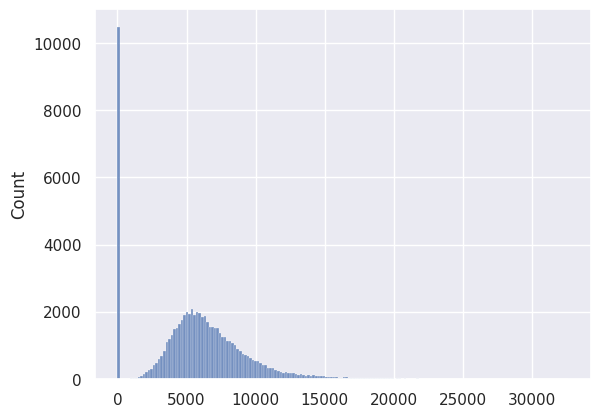

In [73]:
sns.histplot(predictions)

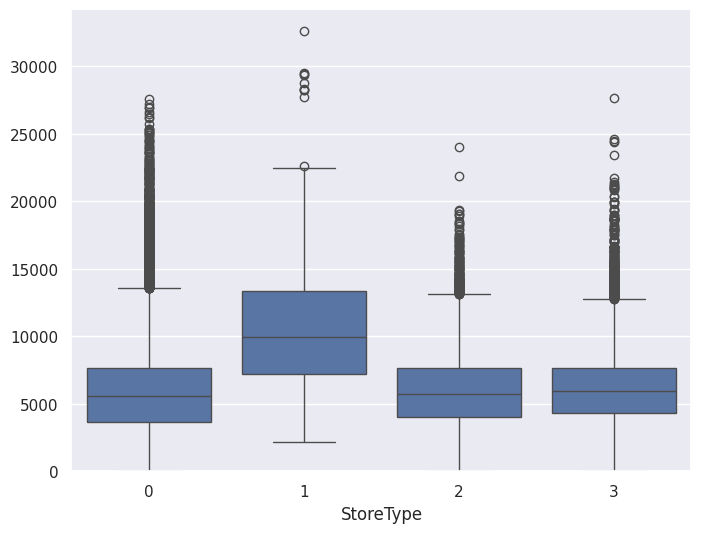

In [74]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=x_test['StoreType'], y=predictions)
fig.axis(ymin=0);

In [75]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Mean_Wind_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,ShoppingCart,Saleslog,Customerslog,Mean_TemperatureClog,CompetitionDistancelog
7056,1,5,2015-05-29,4656,537,1,0,0,0,2,...,11,2.03,6.0,Rain,211,8.67,8.445912,6.285998,2.639057,7.146772
7057,56,5,2015-05-29,10565,669,1,0,0,0,3,...,11,2.03,6.0,Rain,211,15.79,9.265302,6.505784,2.639057,8.797851
7058,69,5,2015-05-29,9172,1232,1,0,0,0,2,...,11,2.03,6.0,Rain,211,7.44,9.123911,7.116394,2.639057,7.029973
7059,77,5,2015-05-29,7478,657,1,0,0,0,3,...,11,2.03,6.0,Rain,211,11.38,8.919721,6.487684,2.639057,6.993933
7060,111,5,2015-05-29,7472,620,1,0,0,0,3,...,11,2.03,6.0,Rain,211,12.05,8.918918,6.429719,2.639057,8.973351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,860,2,2013-01-01,0,0,0,0,a,1,2,...,23,6.10,6.0,Rain,234,0.00,0.000000,0.000000,1.791759,8.696176
1017205,1008,2,2013-01-01,0,0,0,0,a,1,0,...,23,6.10,6.0,Rain,234,0.00,0.000000,0.000000,1.791759,3.401197
1017206,1059,2,2013-01-01,0,0,0,0,a,1,2,...,23,6.10,6.0,Rain,234,0.00,0.000000,0.000000,1.791759,8.125631
1017207,1063,2,2013-01-01,0,0,0,0,a,1,0,...,23,6.10,6.0,Rain,234,0.00,0.000000,0.000000,1.791759,8.740337


In [76]:
opened_weekend = x_test[(x_test['Open'] == 1) & (x_test['SchoolHoliday'] != 0) & (x_test['DayOfWeek'] >= 6)]
opened_weekend     #sklepy otwarte w dni wolne od szkoły, wyjątkiem jest sklep 562 jako jedyny otwarty w niedziele

,Store,StoreType,Customers,CloudCover,DayOfWeek,Promo,Open,SchoolHoliday,Mean_TemperatureC,CompetitionDistance
674590,562,1,3397,5.0,7,0,1,1,16,1210.0
674603,10,0,475,5.0,6,0,1,1,19,3160.0
674604,70,2,550,5.0,6,0,1,1,19,4840.0
674605,107,0,941,5.0,6,0,1,1,19,1930.0
674606,112,0,691,5.0,6,0,1,1,19,1630.0
674607,268,0,389,5.0,6,0,1,1,19,4520.0
674608,304,0,657,5.0,6,0,1,1,19,1950.0
674609,379,3,324,5.0,6,0,1,1,19,6630.0
674610,504,2,774,5.0,6,0,1,1,19,820.0
674611,511,0,738,5.0,6,0,1,1,19,2060.0


In [77]:
test.loc[test['Store'] == 562]['StateName']

674480    Niedersachsen
674502    Niedersachsen
674524    Niedersachsen
674546    Niedersachsen
674568    Niedersachsen
              ...      
675756    Niedersachsen
675778    Niedersachsen
675800    Niedersachsen
675822    Niedersachsen
675844    Niedersachsen
Name: StateName, Length: 63, dtype: object

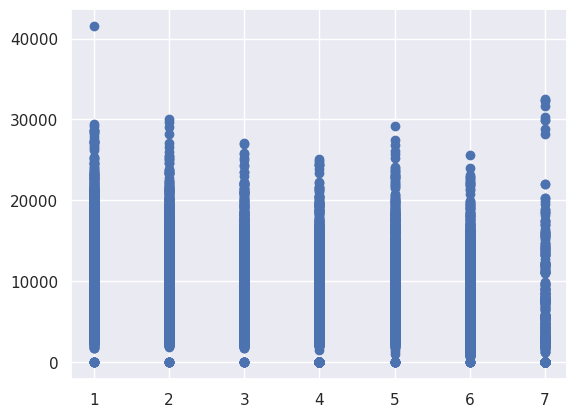

In [78]:
plt.scatter(x_test['DayOfWeek'], y_test)

In [79]:
workdays = test.loc[test['DayOfWeek'] < 6]['Sales']
workdays

0          5263
1         10022
2         11204
3         10335
4          8897
          ...  
992536     8755
992537     9249
992538    12339
992539     7088
992540    27203
Name: Sales, Length: 50175, dtype: int64

In [80]:
workdays = test.loc[test['DayOfWeek'] < 6]['Sales']
weekdays = test.loc[test['DayOfWeek'] >= 6]['Sales']
workdays_sample = workdays.sample(len(weekdays), random_state=0)
stats.ttest_ind(workdays_sample, weekdays)

TtestResult(statistic=126.3617492591598, pvalue=0.0, df=40138.0)

In [81]:
# test A/B pozwala stwierdzić, że zbiory sprzedaży w dni tygodnia i w weekendy są różne od siebie